In [ ]:
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v86)
library(ggplot2)
library(patchwork)
library(hdf5r) 
library(future)
library(RColorBrewer)
library(dplyr)
library(Matrix)
library(BSgenome.Hsapiens.UCSC.hg38)
library(glue)
library(harmony)
library(matrixStats)
library(scales)
library(biomaRt)
library(curl)
library(goseq)
library(httr)
library(Scillus)
library(TFBSTools)
library(JASPAR2020)
library(ggridges)
library(ggrepel)
library(ggsignif)
library(qusage)
library(tidyverse)
httr::set_config(config(ssl_verifypeer = 0L))
set.seed(1234)
setwd('data/inhouse_wu_long_yu')

In [ ]:
source('../../snatac-rcc-manuscript-data/functions.r')

# Figure S4A: IFN-associated ERV accessibility and BAP1 mutation status

Create seurat object containing ccRCC tumor cells that passed peak-level QC and were quantified by scTE

In [5]:
# Read in our object with QC info and cell type annotations
allcells = readRDS('allcells/seurat_obj/integrated_allcohorts_seuratobj_geneactivity_lsi_metadata_qc_motifs_annotated_detailed.rds')
celltype_metadata = allcells@meta.data %>% dplyr::select(c('broad_celltype_excluded', 'biopsy'))
## Peak-QC passing barcodes
allcellsqc_barcodes = row.names(allcells@meta.data %>% filter(broad_celltype_excluded != 'Excluded'))
rm(allcells)

# Read in TE counts matrix
te_counts = read.table('scte/preprocessing/unfiltered_combined_scte.txt', sep = '\t', header = TRUE)
row.names(te_counts) = te_counts$barcodes
te_barcodes = te_counts$barcodes

# Define a set of barcodes that passed peak-based QC and have TE's quantified, subset counts matrix by these
peakqc_tecounts_barcodes = intersect(allcellsqc_barcodes, te_barcodes)
## Subset TE counts matrix
te_countsqc = te_counts %>% filter(barcodes %in% peakqc_tecounts_barcodes) 
te_countsqc$barcodes = NULL
te_countsqc = data.frame(t(te_countsqc), check.names = FALSE)

# Add to allcells seurat object, log normalize data
te_obj = CreateSeuratObject(counts = te_countsqc, assay = 'scte', meta.data = celltype_metadata, min.cells = 10, min.features = 200)
te_obj <- NormalizeData(
   object = te_obj,
  assay = 'scte',
  normalization.method = 'LogNormalize',
    scale.factor = median(te_obj$nCount_scte)
)

# load in ccrcc object and subset to cells that also have TE counts
ccrcc = readRDS('allcells/tumor/seurat_obj/integrated_ccrcc_c0123_plof_anno_Oct2023.rds')
incommon = intersect(row.names(ccrcc@meta.data), row.names(te_obj@meta.data))
ccrcc_te_atac = subset(ccrcc, cells = incommon)

# subset TE object to ccRCC tumor cells
ccrcc_te_obj = subset(te_obj, cells = row.names(ccrcc@meta.data))

# add TE assay to ccRCC ATAC object to create an object that stores both types of data
ccrcc_te_atac[['scte']] <- ccrcc_te_obj[['scte']]

Warning message in CreateSeuratObject.default(counts = te_countsqc, assay = "scte", :
"Some cells in meta.data not present in provided counts matrix"
Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


Define set of ERVs found to be associated with IFN signaling

In [35]:
ifn_sig_results = read.table('../../snatac-rcc-manuscript-data/s4f_erv_ifn_associations.txt', sep = '\t', check.names = F, header = T)
ifn1_fts = (ifn_sig_results %>%
    filter(group == 'IFN1'))$feature
ifng_fts = (ifn_sig_results %>%
    filter(group == 'IFNG'))$feature
ifn_fts = intersect(ifn1_fts,ifng_fts)
# Formatting to match what R did to the ERV names
ifn_fts = gsub("-", "_", ifn_fts)
ifn_fts = gsub("\\.", "-", ifn_fts)
ifn_fts = gsub("_", "\\.", ifn_fts)
length(ifn_fts)

[1] 19

Place IFN-associated ERV counts into metadata column to facilitate plotting

In [36]:
# Place IFN-associated ERV counts into metadata column to facilitate plotting
sig_avg_mtx = data.frame(t(ccrcc_te_atac@assays$scte@data[ifn_fts,]), check.names = FALSE)
ccrcc_te_atac = AddMetaData(object = ccrcc_te_atac, metadata = sig_avg_mtx)
fts = colnames(ccrcc_te_atac@meta.data[,c(112:130)])

Warning message:
"Invalid name supplied, making object name syntactically valid. New object name is ERV24B.Prim.intERV3.16A3.I.intERV3.16A3.LTRERVL.E.intERVL47.intHERV15.intHERV3.intHERV9N.intHERVE.intHERVE.a.intHERVH.intHERVH48.intHERVIP10B3.intHERVIP10FH.intHERVK13.intHERVK9.intHERVKC4.intHERVL.intHERVL66.int; see ?make.names for more details on syntax validity"


Compare accessibility of each IFN associated ERV and plot

`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Warning message in wilcox.test.default(mt, wt, alternative = "greater"):
"cannot compute exact p-value with ties"
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Warning message in wilcox.test.default(mt, wt, alternative = "greater"):
"cannot compute exact p-value with ties"
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
Warning message in wilcox.test.default(mt, wt, alternative = "greater"):
"cannot compute exact p-value with ties"
`summarise()` has grouped output by 'biopsy'. You can override using the `.groups` argument.
`summar

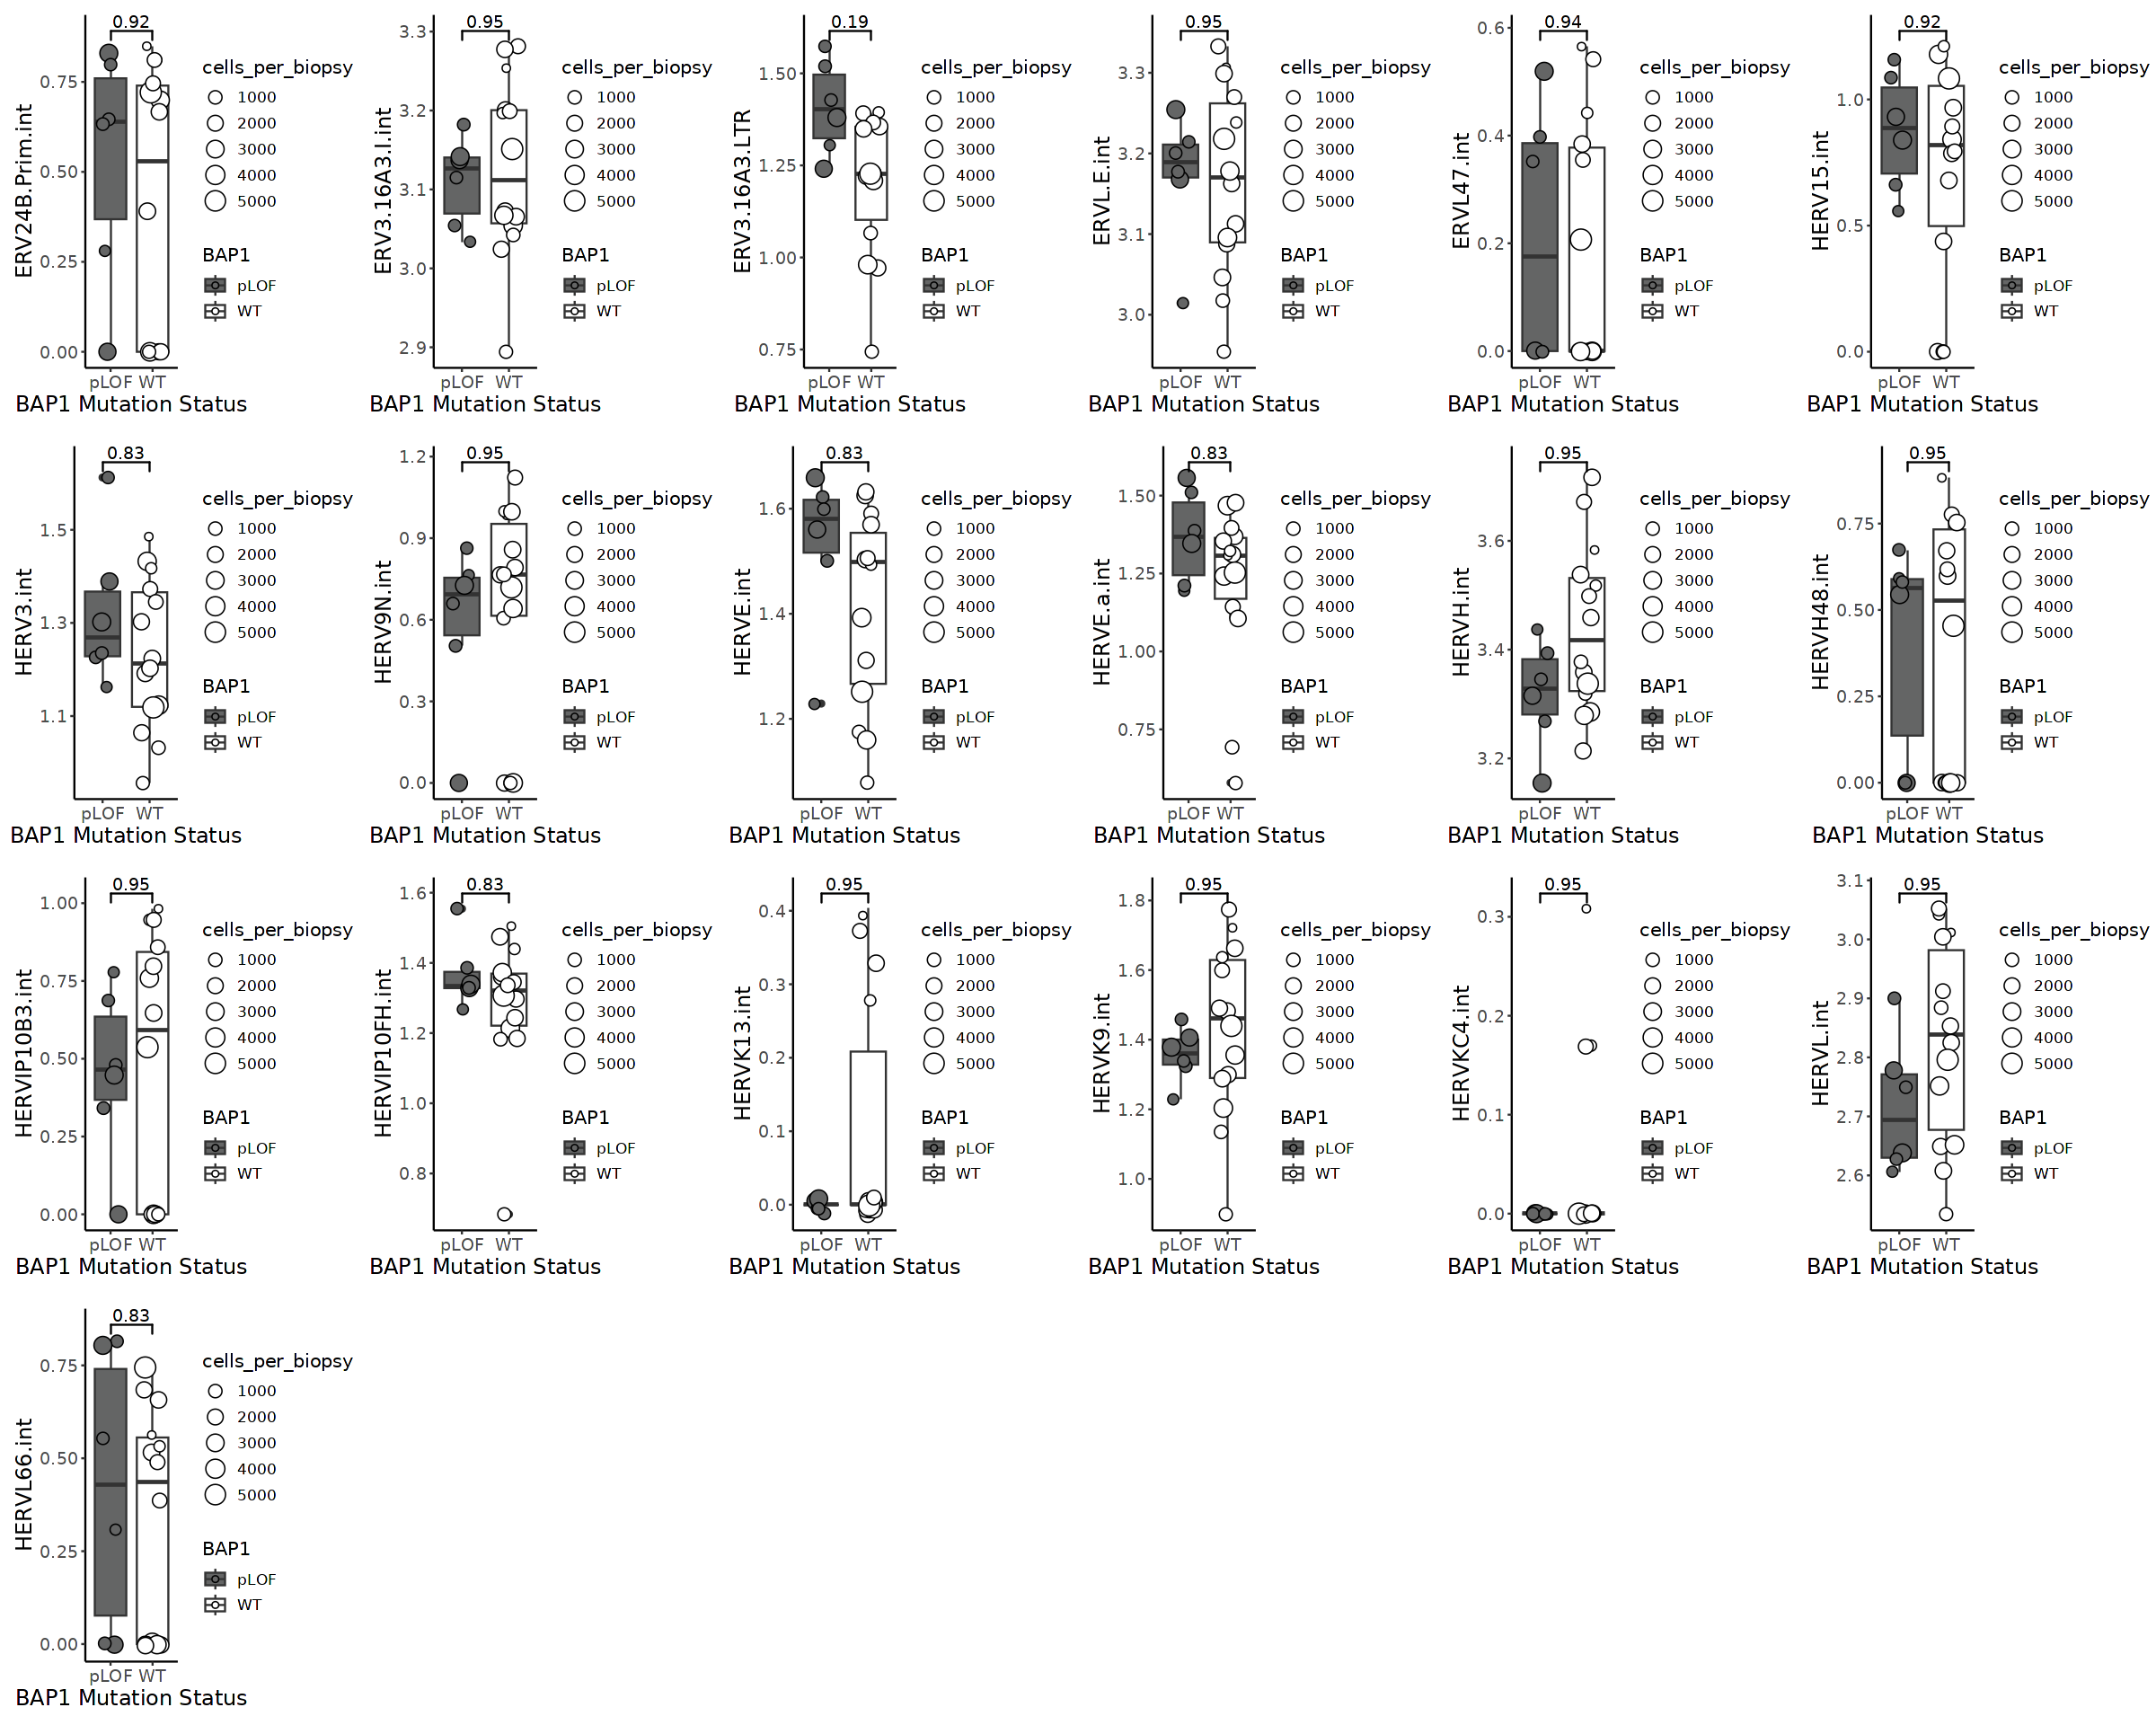

In [38]:
# Subset to late stage BAP1 pLOF or WT
late_meta = ccrcc_te_atac@meta.data %>% filter((stage %in% c(3,4)) & ((BAP1_LOF == 1) | (BAP1 == 0)))
late_meta[,'BAP1'] = ifelse(late_meta[,'BAP1'] == 1, 'pLOF', 'WT')
late_meta[,'BAP1'] = factor(late_meta[,'BAP1'], levels = c('pLOF','WT'))

# Determine adjusted p-value per comparison
grouped_erv_list = list()
for (i in 1:length(fts)) {
    ft = fts[i]
    df = late_meta %>% group_by(biopsy, BAP1) %>%
        summarise(
        median_sig = median(!!sym(ft)))
    wt = (df %>% filter(BAP1 == 'WT'))$median_sig
    mt = (df %>% filter(BAP1 == 'pLOF'))$median_sig
    pval = (wilcox.test(mt, wt, alternative = 'greater'))$p.value
    y_scale_range = max(c(wt,mt)) - min(c(wt,mt))
    ypos = max(c(wt,mt)) + y_scale_range * 0.05

    grouped_erv_list[[ft]] = data.frame(ERV = ft, p_val = pval, ypos = ypos)
}
grouped_erv_df = dplyr::bind_rows(grouped_erv_list)
grouped_erv_df$p_adjust = p.adjust(grouped_erv_df$p_val, method = 'fdr')

# Plot
options(repr.plot.width=5, repr.plot.height=5)
plots = list()
for (i in 1:length(fts)) {
    ft = fts[i]
    plots[[i]] = plot_signature_by_mutation(data = late_meta, mutation_column = "BAP1", signature = ft)+
            scale_size(range = c(2, 6)) + scale_fill_manual(values = c('#646565', 'white')) + geom_signif(
    xmin = 'pLOF', xmax = 'WT', y_position = (grouped_erv_df %>% filter(ERV == ft))$ypos,
    annotation = c(formatC((grouped_erv_df %>% filter(ERV == ft))$p_adjust, digits = 2)))
}
options(repr.plot.width=20, repr.plot.height=16)
cowplot::plot_grid(plotlist = plots, ncol = 6)

# Table S4

## Sheet A-B: IFN1 and IFNG epigenetic signatures

Peaks are from the mixed effects model associating a given peak's accessibility with cytosig derived IFN scores. We only tested peaks called in the tumor cluster and >5% pct.accessible (5% w/ non-zero accessibility, from dotplot) n = 80768 tests. 

`lmer(pk_accessibility ~ ifn_score + seq_depth + (1|sample), data = data_for_model)`

In [39]:
# set of peaks nominally significant with positive coefficient
ifn1_me = readRDS('scte/cytosig/ifn1_sample_fivep_mixedeffects_assoc_peaks.RDS')
ifn1_me$p.value = ifn1_me[,5]
ifn1_me[,5] = NULL
ifn1_me$feature = as.character(ifn1_me$feature)
ifn1_me_sig = ifn1_me %>% filter((p.value < 0.05) & (Estimate > 0))
write.table(ifn1_me_sig, '../../snatac-rcc-manuscript-data/s4a_IFN1_peak_set.txt', sep = '\t', quote = F, col.names = T, row.names = F)
# set of peaks nominally significant with positive coefficient
ifng_me = readRDS('scte/cytosig/ifng_sample_fivep_mixedeffects_assoc_peaks.RDS')
ifng_me$p.value = ifng_me[,5]
ifng_me[,5] = NULL
ifng_me$feature = as.character(ifng_me$feature)
ifng_me_sig = ifng_me %>% filter((p.value < 0.05) & (Estimate > 0))
write.table(ifng_me_sig, '../../snatac-rcc-manuscript-data/s4b_IFNG_peak_set.txt', sep = '\t', quote = F, col.names = T, row.names = F)


## Sheet C-D: TF binding site motif enrichment in IFN1 and IFNG epigenetic signatures

Saved in figure4 notebook. 

## Sheet E: Pathways enriched in IFN epigenetic signatures

In [5]:
header = read.table('allcells/tumor/great/greatExportAll_forheader.tsv', fill = TRUE, sep = "\t", quote = "", row.names = NULL)
header = unlist(unname(t(header[1,])[,1]))
keep = c('GO Biological Process','MSigDB Pathway')
results = list()

IFN1

In [6]:
great_results = read.table('scte/cytosig/GREAT/ifn1_mixedeffects_nominalp_peaks_RESULTS.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]
# GREAT default term filtering
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 
great_results$group = 'IFN1'
results[['IFN1']] = great_results
dim(great_results)

[1] 45 23

IFNG

In [7]:
great_results = read.table('scte/cytosig/GREAT/ifng_mixedeffects_nominalp_peaks_RESULTS.tsv',  sep = "\t", quote = "", row.names = NULL, fill = TRUE)
colnames(great_results) = header
great_results = great_results[,-c(23,24)]
# GREAT default term filtering
great_results = great_results %>%
filter((Ontology %in% keep) &
       (RegionFoldEnrich > 2) &
        (TotalGenes > 1) &
        (BinomFdrQ < 0.05) &
        (HyperFdrQ < 0.05)) 
great_results$group = 'IFNG'
results[['IFNG']] = great_results
dim(great_results)

[1] 106  23

In [8]:
write.table(dplyr::bind_rows(results), '../../snatac-rcc-manuscript-data/s4e_IFN1_IFNG_GREAT_GOBP_MSigDB_output.txt', sep = '\t', quote = F, row.names = F, col.names = T)

## Sheet F: IFN-associated ERVs

Saved in figure4 notebook

## Writing out tables to Excel workbook

In [1]:
import pandas as pd

In [3]:
ifn1_peaks = pd.read_csv('snatac-rcc-manuscript-data/s4a_IFN1_peak_set.txt', sep = '\t')
ifn1_peaks.head()

ifng_peaks = pd.read_csv('snatac-rcc-manuscript-data/s4b_IFNG_peak_set.txt', sep = '\t')
ifng_peaks.head()

ifn1_tf_motifs = pd.read_csv('snatac-rcc-manuscript-data/s4c_IFN1_tfmotifs.txt', sep = '\t')
ifn1_tf_motifs.head()

ifng_tf_motifs = pd.read_csv('snatac-rcc-manuscript-data/s4d_IFNG_tfmotifs.txt', sep = '\t')
ifng_tf_motifs.head()

ifn_pathways = pd.read_csv('snatac-rcc-manuscript-data/s4e_IFN1_IFNG_GREAT_GOBP_MSigDB_output.txt', sep = '\t')
ifn_pathways.head()

ifn_assoc_ervs = pd.read_csv('snatac-rcc-manuscript-data/s4f_erv_ifn_associations.txt', sep = '\t')
ifn_assoc_ervs['feature'] = ifn_assoc_ervs['feature'].str.replace('.', '_', regex=True)
ifn_assoc_ervs.head()


,Estimate,Std. Error,df,t value,Pr(>|t|),feature,p.adjust,group
0,0.000522,0.000178,82521.565686,2.933866,3.348605e-03,ERV24B_Prim-int,8.444307e-03,IFN1
1,0.001461,0.000274,82531.896888,5.331426,9.769959e-08,ERV3-16A3_I-int,3.541610e-07,IFN1
2,0.001678,0.000161,82522.793434,10.401656,2.526145e-25,ERV3-16A3_LTR,2.093092e-24,IFN1
3,0.000523,0.000219,82529.352975,2.382708,1.718807e-02,ERVL-B4-int,3.834261e-02,IFN1
4,0.001474,0.000288,82531.371630,5.118087,3.093411e-07,ERVL-E-int,1.055399e-06,IFN1


In [4]:
with pd.ExcelWriter('snatac-rcc-manuscript-data/table_S4.xlsx') as writer:  
    ifn1_peaks.to_excel(writer, sheet_name='A', index = False)
    ifng_peaks.to_excel(writer, sheet_name='B', index = False)
    ifn1_tf_motifs.to_excel(writer, sheet_name='C', index = False)
    ifng_tf_motifs.to_excel(writer, sheet_name='D', index = False)
    ifn_pathways.to_excel(writer, sheet_name='E', index = False)
    ifn_assoc_ervs.to_excel(writer, sheet_name='F', index = False)

Add README with titles in excel app. 